# Proof of concept
## Get PES of AL2
- taken from: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/vqe-molecules.ipynb

In [1]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

import numpy as np
# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator as AerEstimator

In [2]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Al", "Al"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()

    # Now you can get the reduced electronic structure problem
    from qiskit_nature.second_q.transformers import FreezeCoreTransformer

    fc_transformer = FreezeCoreTransformer()

    fc_problem = fc_transformer.transform(problem)

    # active space transformer
    from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

    as_transformer = ActiveSpaceTransformer(2, 2)

    as_problem = as_transformer.transform(fc_problem)
    
    num_particles = as_problem.num_particles
    num_spatial_orbitals = as_problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(as_problem.second_q_ops()[0])
    print (f"Problem spatial orbitals {problem.num_spatial_orbitals}")
    print (f"Problem particles {problem.num_particles}")
    print (f"FC-Problem spatial orbitals {fc_problem.num_spatial_orbitals}")
    print (f"FC-Problem particles {fc_problem.num_particles}")
    print (f"AS-Problem spatial orbitals {as_problem.num_spatial_orbitals}")
    print (f"AS-Problem particles {as_problem.num_particles}")
    return qubit_op, num_particles, num_spatial_orbitals, as_problem, mapper

In [3]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(1.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.5 VQE Result: -477.44904 Exact Energy: -477.48401
Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.6 VQE Result: -477.54879 Exact Energy: -477.58234
Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.7 VQE Result: -477.61970 Exact Energy: -477.65193
Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed

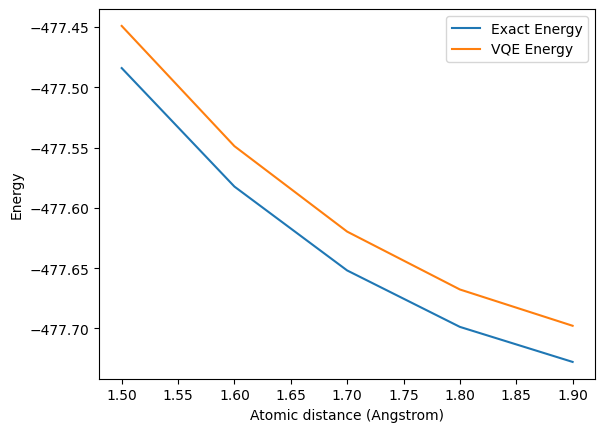

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

## Now get this thing run on real-hw

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)

In [12]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [16]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(1.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
estimator = Estimator(backend)

# pylint: disable=undefined-loop-variable,line-too-long
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(1.8)

result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD(
    num_spatial_orbitals, num_particles, mapper, initial_state=init_state
)

print(f"Qubits needed in ansatz: {var_form.num_qubits}")
print(f"Parameters needed in ansatz: {var_form.num_parameters}")

#now convert to hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(var_form) 
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

x0 = initial_point=[0] * var_form.num_parameters

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )


print(
    f"Interatomic Distance: {np.round(dist, 2)}",
    f"Exact Energy: {exact_energies[-1]:.5f}",
)

print("All energies have been calculated")

Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Parameters needed in ansatz: 3
Iters. done: 1 [Current cost: -0.38955542183236197]
Iters. done: 2 [Current cost: -0.41074992403133087]
Iters. done: 3 [Current cost: -0.3895051006876079]
Iters. done: 4 [Current cost: -0.40623943141665253]
Iters. done: 5 [Current cost: -0.4014743998577841]
Iters. done: 6 [Current cost: -0.4184948108572262]
Iters. done: 7 [Current cost: -0.40932367014749843]
Iters. done: 8 [Current cost: -0.4182415131231815]
Iters. done: 9 [Current cost: -0.41446019406653906]
Iters. done: 10 [Current cost: -0.41445882607116413]
Iters. done: 11 [Current cost: -0.41891377558502313]
Iters. done: 12 [Current cost: -0.41924356233458704]
Iters. done: 13 [Current cost: -0.4175007887482544]
Iters. done: 14 [Current cost: -0.41903512544711613]
Iters. done: 15 [Current cost: -0.419143430

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

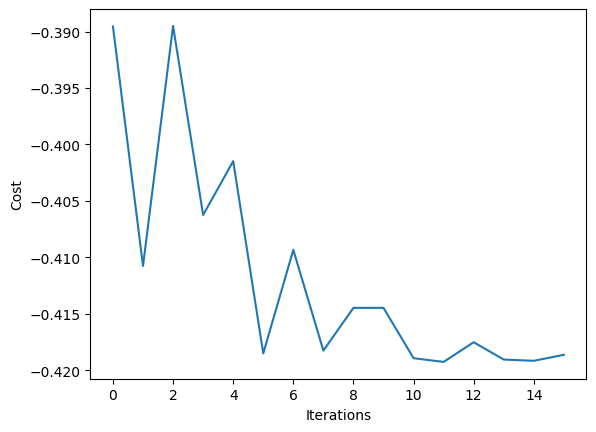

In [17]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## Try above running locally

In [22]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit.primitives import StatevectorEstimator

In [23]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [24]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [26]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(1.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
estimator = StatevectorEstimator()

# pylint: disable=undefined-loop-variable,line-too-long
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(1.8)

result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD(
    num_spatial_orbitals, num_particles, mapper, initial_state=init_state
)

print(f"Qubits needed in ansatz: {var_form.num_qubits}")
print(f"Parameters needed in ansatz: {var_form.num_parameters}")

#now convert to hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(var_form) 
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

x0 = initial_point=[0] * var_form.num_parameters

#estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
)


print(
    f"Interatomic Distance: {np.round(dist, 2)}",
    f"Exact Energy: {exact_energies[-1]:.5f}",
)

print("All energies have been calculated")

Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Parameters needed in ansatz: 3


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


ValueError: Maximum allowed dimension exceeded

## Now apply zne and run again on fake backend

In [31]:
# create fake backend instance
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka

from qiskit.transpiler import InstructionProperties
fake_backend = FakeTorino()

In [32]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

In [38]:
error_rates = {
    "default_duration": 1e-8,
    "rz_error": 1e-4,
    "x_error": 1e-8,
    "sx_error": 1e-8,
    "measure_error": 1e-8,
    #"cx_error": 1e-4
}

default_shots = 10000

In [39]:
update_error_rate(fake_backend, error_rates)
    
estimator = Estimator(fake_backend)

In [40]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Batch
options_ex6 = EstimatorOptions()
options_ex6.default_shots = default_shots
options_ex6.optimization_level = 0
options_ex6.resilience_level = 2
options_ex6.default_shots = default_shots
options_ex6.dynamical_decoupling.enable=True
options_ex6.dynamical_decoupling.sequence_type= "XX"
options_ex6.twirling.enable_measure=True
options_ex6.twirling.enable_gates=True
options_ex6.resilience.zne_mitigation=True
options_ex6.resilience.measure_mitigation=True
options_ex6.resilience.zne.extrapolator=('linear', 'exponential')
options_ex6.resilience.zne.noise_factors=(1,3,5)

In [41]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

In [42]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [43]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(1.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
#estimator = StatevectorEstimator()

# pylint: disable=undefined-loop-variable,line-too-long
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(1.8)

result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD(
    num_spatial_orbitals, num_particles, mapper, initial_state=init_state
)

print(f"Qubits needed in ansatz: {var_form.num_qubits}")
print(f"Parameters needed in ansatz: {var_form.num_parameters}")

#now convert to hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)

ansatz_isa = pm.run(var_form) 
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

x0 = initial_point=[0] * var_form.num_parameters

estimator = Estimator(backend=fake_backend, options=options_ex6)
estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
)


print(
    f"Interatomic Distance: {np.round(dist, 2)}",
    f"Exact Energy: {exact_energies[-1]:.5f}",
)

print("All energies have been calculated")

Problem spatial orbitals 18
Problem particles (13, 13)
FC-Problem spatial orbitals 8
FC-Problem particles (3, 3)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Parameters needed in ansatz: 3


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 1 [Current cost: -0.3926398853346947]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 2 [Current cost: -0.41028709727708024]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 3 [Current cost: -0.391318727799037]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 4 [Current cost: -0.40629644393183895]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 5 [Current cost: -0.4011972251130787]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 6 [Current cost: -0.4170884278844993]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 7 [Current cost: -0.40773659086210395]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 8 [Current cost: -0.41662578468939937]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 9 [Current cost: -0.4139828177526945]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 10 [Current cost: -0.41381616818783973]


/home/marc/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 10000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('linear', 'exponential')}}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()